In [1]:
# initialize Spark

import pyspark
from pyspark.sql import SparkSession, Row
from pyspark.sql.functions import col, asc,desc
import os
from pyspark.sql.functions import *
import time
conf = pyspark.SparkConf().setAll([('spark.master', 'local[4]'),
                                   ('spark.app.name', 'PySpark DataFrame Demo')])
spark = SparkSession.builder.config(conf=conf).getOrCreate()
spark.conf.set("spark.sql.repl.eagerEval.enabled", True)
print (spark.version, pyspark.version.__version__)

3.1.1 3.1.1


In [2]:
import pprint
import math
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans as sklKMeans
from scipy.interpolate import make_interp_spline
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from pyspark.sql import DataFrame
from pyspark.sql.types import StructType
from pyspark.sql.types import IntegerType,FloatType
from pyspark.sql.functions import unix_timestamp, from_unixtime
from pyspark.sql.functions import  asin, acos, sin, sqrt, cos
from pyspark.sql.functions import pow, col
from datetime import datetime
import pyspark.sql.functions as F
from pyspark.sql.types import DateType
from pyspark.sql.functions import radians
from pyspark.ml.feature import BucketedRandomProjectionLSH
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler

from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

pp = pprint.PrettyPrinter(indent=4)

In [3]:
def get_columns(df_list, counts=False):
    df_dict = {}
    for df in df_list:
        df_dict[namestr(df)] = {}
        if(counts):
            df_dict[namestr(df)]['count'] = df.count()
        else:
            df_dict[namestr(df)]['columns'] = df.schema.names
            df_dict[namestr(df)]['count'] = df.count()
    
    return df_dict

def namestr(obj, namespace=globals()):
    return [name for name in namespace if namespace[name] is obj][0]

In [4]:
DATA_PATH="hdfs:///data/"
df_customers = spark.read.csv(DATA_PATH+"customers_dataset.csv", header=True)
df_customer_reviews = spark.read.csv(DATA_PATH+"customer_reviews_dataset.csv", header=True)
df_geolocation = spark.read.csv(DATA_PATH+"geolocation_dataset.csv", header=True)
df_orders = spark.read.csv(DATA_PATH+"orders_dataset.csv", header=True)
df_order_items = spark.read.csv(DATA_PATH+"order_items_dataset.csv", header=True)
df_order_payments = spark.read.csv(DATA_PATH+"order_payments_dataset.csv", header=True)
df_sellers = spark.read.csv(DATA_PATH+"sellers_dataset.csv", header=True)
df_products = spark.read.csv(DATA_PATH+"products_dataset.csv", header=True)
df_product_category_name_translation = spark.read.csv(DATA_PATH+"product_category_name_translation.csv", header=True)

# This will restrict the datasets and prevent kernel crashes while running 
N_TRAIN_DATA = 30000
N_TEST_DATA = 20000


In [5]:
df_list = [df_customers,
           df_customer_reviews,
           df_geolocation,
           df_orders,
           df_order_items,
           df_order_payments,
           df_sellers,
           df_products,
           df_product_category_name_translation]

pp.pprint(get_columns(df_list))

{   'df_customer_reviews': {   'columns': [   'review_id',
                                              'order_id',
                                              'survey_score',
                                              'survey_review_title',
                                              'survey_review_content',
                                              'survey_send_date',
                                              'survey_completion_date'],
                               'count': 105189},
    'df_customers': {   'columns': [   'customer_id',
                                       'customer_unique_id',
                                       'customer_zip_code_prefix',
                                       'customer_city',
                                       'customer_state'],
                        'count': 99441},
    'df_geolocation': {   'columns': [   'geo_zip_code_prefix',
                                         'geo_lat',
                                        

## Data cleaning
  * ### Drop NA

In [6]:
for df in df_list:
    df = df.dropna()

pp.pprint(get_columns(df_list, True))

{   'df_customer_reviews': {'count': 105189},
    'df_customers': {'count': 99441},
    'df_geolocation': {'count': 1000163},
    'df_order_items': {'count': 112650},
    'df_order_payments': {'count': 103886},
    'df_orders': {'count': 99441},
    'df_product_category_name_translation': {'count': 71},
    'df_products': {'count': 32951},
    'df_sellers': {'count': 3095}}


  * ### Filter out only intergers for the customer reviews

In [7]:
df_customer_reviews = df_customer_reviews[
                        (df_customer_reviews['survey_score']=='0')|
                        (df_customer_reviews['survey_score']=='1')|
                        (df_customer_reviews['survey_score']=='2')|
                        (df_customer_reviews['survey_score']=='3')|
                        (df_customer_reviews['survey_score']=='4')|
                        (df_customer_reviews['survey_score']=='5')
                        ]
# do the type conversion of the text score to integer
df_customer_reviews = df_customer_reviews.withColumn('survey_score', df_customer_reviews['survey_score'].cast(IntegerType()))

  * ### Remove duplicate geolocations

In [8]:
print("Raw data count = {}".format(df_geolocation.count()))
df_geolocation = df_geolocation.dropDuplicates(['geo_zip_code_prefix'])
print("Data count after dropping duplicates = {}".format(df_geolocation.count()))

Raw data count = 1000163
Data count after dropping duplicates = 19015


## Merge order_items, product_category into products 

In [9]:
df_grp_product_cat = df_order_items.join(df_products, on=['product_id'], how='inner')
df_grp_product_cat = df_grp_product_cat.dropna(subset=["product_category_name"])
pp.pprint(get_columns([df_grp_product_cat]))
df_grp_product_cat = df_grp_product_cat.dropna()
df_order_merged = df_grp_product_cat.join(df_orders, on=['order_id'], how='inner')
df_order_merged = df_order_merged.dropna()
pp.pprint(get_columns([df_order_merged]))

# df_grp_product_cat.dropna().count()

{   'df_grp_product_cat': {   'columns': [   'product_id',
                                             'order_id',
                                             'order_item_id',
                                             'seller_id',
                                             'shipping_limit_date',
                                             'price',
                                             'freight_value',
                                             'product_category_name',
                                             'product_name_lenght',
                                             'product_description_lenght',
                                             'product_photos_qty',
                                             'product_weight_g',
                                             'product_length_cm',
                                             'product_height_cm',
                                             'product_width_cm'],
                              'count'

## Data Conversion

In [10]:
# Convert to integer Type
name_type = ['shipping_limit_date']
int_col = ['product_photos_qty',
           'product_height_cm', 
           'product_length_cm', 
           'product_weight_g', 
           'product_width_cm', 
           'product_name_lenght', 
           'product_description_lenght']
float_col = ['price', 
             'freight_value'] 


for k in range(len(name_type)):
    df_order_merged = df_order_merged.drop(name_type[k])
    
for k in range(len(int_col)):
    df_order_merged = df_order_merged.withColumn(int_col[k], df_order_merged[int_col[k]].cast(IntegerType()))

for k in range(len(float_col)):
    df_order_merged = df_order_merged.withColumn(float_col[k], df_order_merged[float_col[k]].cast(FloatType()))    

display(df_order_merged.schema)

StructType(List(StructField(order_id,StringType,true),StructField(product_id,StringType,true),StructField(order_item_id,StringType,true),StructField(seller_id,StringType,true),StructField(price,FloatType,true),StructField(freight_value,FloatType,true),StructField(product_category_name,StringType,true),StructField(product_name_lenght,IntegerType,true),StructField(product_description_lenght,IntegerType,true),StructField(product_photos_qty,IntegerType,true),StructField(product_weight_g,IntegerType,true),StructField(product_length_cm,IntegerType,true),StructField(product_height_cm,IntegerType,true),StructField(product_width_cm,IntegerType,true),StructField(customer_id,StringType,true),StructField(order_status,StringType,true),StructField(order_purchase_timestamp,StringType,true),StructField(order_approved_at,StringType,true),StructField(order_carrier_delivery_date,StringType,true),StructField(order_customer_delivery_date,StringType,true),StructField(order_estimated_delivery_date,StringType

## Product dimesnsions 
  - ### multiply l x w x h and get rid of the l,w,h columns, name the resulting volume calculation as \_dim 

In [11]:
df_order_merged = df_order_merged.withColumn('product_dim_cm', df_order_merged['product_length_cm']*df_order_merged['product_height_cm']*df_order_merged['product_width_cm'])

df_order_merged  = df_order_merged.drop('product_length_cm', 'product_height_cm', 'product_width_cm')

df_order_merged.schema.names

['order_id',
 'product_id',
 'order_item_id',
 'seller_id',
 'price',
 'freight_value',
 'product_category_name',
 'product_name_lenght',
 'product_description_lenght',
 'product_photos_qty',
 'product_weight_g',
 'customer_id',
 'order_status',
 'order_purchase_timestamp',
 'order_approved_at',
 'order_carrier_delivery_date',
 'order_customer_delivery_date',
 'order_estimated_delivery_date',
 'product_dim_cm']

  - ### Effect of product dimensions on the orders 

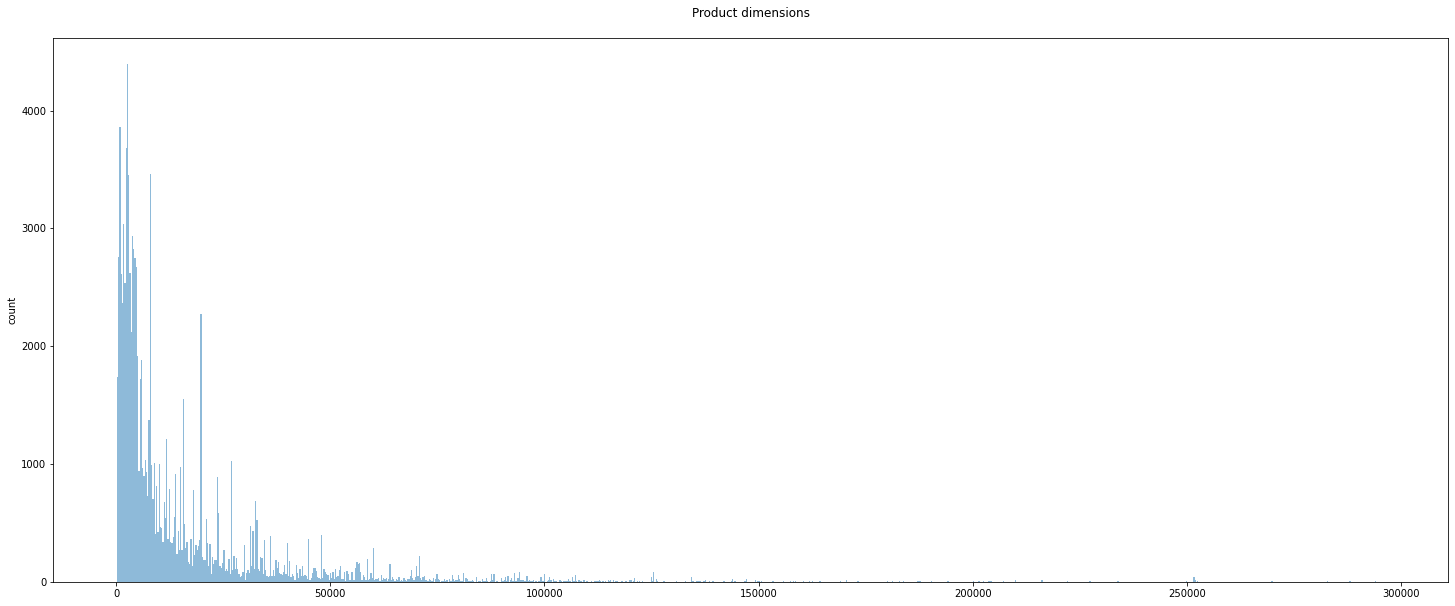

,product_dim_cm
count,108643.000000
mean,15220.920750
std,23264.215598
min,168.000000
25%,2856.000000
50%,6552.000000
75%,18375.000000
max,296208.000000


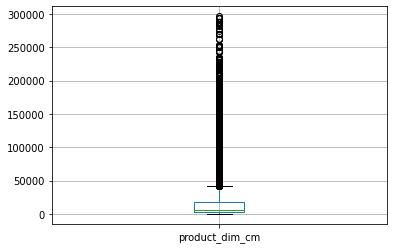

In [12]:
product_dims = df_order_merged.select('product_dim_cm').toPandas()
fig = plt.figure(figsize=(25, 10))
ax = product_dims['product_dim_cm'].plot.hist(bins=1000, alpha=0.5)
ax.set_ylabel("count")
plt.title(f"Product dimensions\n")
plt.show()
product_dims.boxplot(column=['product_dim_cm'])
display(product_dims.describe())

## Geolocation

  - ### Get the lat,lng for sellers and customers  

In [13]:
df_geolocation.schema.names
#df_order_merged.join(df_order_merged) 
df_order_merged = df_order_merged.join(df_sellers.drop('seller_city','seller_state'), on=['seller_id'], how='inner')
df_order_merged = df_order_merged.join(df_customers.drop('customer_unique_id', 'customer_city', 'customer_state'), on=['customer_id'], how='inner')
df_order_merged = df_order_merged.join(df_geolocation.selectExpr(" geo_zip_code_prefix as seller_zip_code_prefix", "geo_lat as seller_lat", "geo_lng as seller_lng"), on=['seller_zip_code_prefix'], how='inner')
df_order_merged = df_order_merged.join(df_geolocation.selectExpr(" geo_zip_code_prefix as customer_zip_code_prefix", "geo_lat as customer_lat", "geo_lng as customer_lng"), on=['customer_zip_code_prefix'], how='inner')
df_order_merged = df_order_merged.dropna()
display(get_columns([df_order_merged]))

{'df_order_merged': {'columns': ['customer_zip_code_prefix',
   'seller_zip_code_prefix',
   'customer_id',
   'seller_id',
   'order_id',
   'product_id',
   'order_item_id',
   'price',
   'freight_value',
   'product_category_name',
   'product_name_lenght',
   'product_description_lenght',
   'product_photos_qty',
   'product_weight_g',
   'order_status',
   'order_purchase_timestamp',
   'order_approved_at',
   'order_carrier_delivery_date',
   'order_customer_delivery_date',
   'order_estimated_delivery_date',
   'product_dim_cm',
   'seller_lat',
   'seller_lng',
   'customer_lat',
   'customer_lng'],
  'count': 108113}}

  - ### Haversine calculation for distance
    - **convert all the lat,lng into radians and drop original lat,lng**

In [14]:

df_order_merged = df_order_merged.withColumn('seller_lat_rad',radians(df_order_merged['seller_lat']))
df_order_merged = df_order_merged.withColumn('seller_lng_rad',radians(df_order_merged['seller_lng']))
df_order_merged = df_order_merged.withColumn('customer_lat_rad',radians(df_order_merged['customer_lat']))
df_order_merged = df_order_merged.withColumn('customer_lng_rad',radians(df_order_merged['customer_lng']))

df_order_merged = df_order_merged.drop('seller_lat')
df_order_merged = df_order_merged.drop('seller_lng')
df_order_merged = df_order_merged.drop('customer_lat')
df_order_merged = df_order_merged.drop('customer_lng')

display(get_columns([df_order_merged]))

{'df_order_merged': {'columns': ['customer_zip_code_prefix',
   'seller_zip_code_prefix',
   'customer_id',
   'seller_id',
   'order_id',
   'product_id',
   'order_item_id',
   'price',
   'freight_value',
   'product_category_name',
   'product_name_lenght',
   'product_description_lenght',
   'product_photos_qty',
   'product_weight_g',
   'order_status',
   'order_purchase_timestamp',
   'order_approved_at',
   'order_carrier_delivery_date',
   'order_customer_delivery_date',
   'order_estimated_delivery_date',
   'product_dim_cm',
   'seller_lat_rad',
   'seller_lng_rad',
   'customer_lat_rad',
   'customer_lng_rad'],
  'count': 108113}}

   - **Get the difference between lat, lng seller and customer**

In [15]:
df_order_merged = df_order_merged.withColumn('dlng',(df_order_merged['seller_lng_rad'] - df_order_merged['customer_lng_rad'])/2)
df_order_merged = df_order_merged.withColumn('dlat',(df_order_merged['seller_lat_rad'] - df_order_merged['customer_lat_rad'])/2)
display(get_columns([df_order_merged]))

{'df_order_merged': {'columns': ['customer_zip_code_prefix',
   'seller_zip_code_prefix',
   'customer_id',
   'seller_id',
   'order_id',
   'product_id',
   'order_item_id',
   'price',
   'freight_value',
   'product_category_name',
   'product_name_lenght',
   'product_description_lenght',
   'product_photos_qty',
   'product_weight_g',
   'order_status',
   'order_purchase_timestamp',
   'order_approved_at',
   'order_carrier_delivery_date',
   'order_customer_delivery_date',
   'order_estimated_delivery_date',
   'product_dim_cm',
   'seller_lat_rad',
   'seller_lng_rad',
   'customer_lat_rad',
   'customer_lng_rad',
   'dlng',
   'dlat'],
  'count': 108113}}

   - **Calculations for haversine equation**

In [16]:

df_order_merged = df_order_merged.withColumn('dlng_sin', sin(df_order_merged['dlng']))
df_order_merged = df_order_merged.withColumn('dlng_sin_square', pow(df_order_merged['dlng_sin'],2))

df_order_merged = df_order_merged.withColumn('dlat_sin', sin(df_order_merged['dlat']))
df_order_merged = df_order_merged.withColumn('dlat_sin_square', pow(df_order_merged['dlat_sin'],2))

df_order_merged = df_order_merged.withColumn('seller_lat_rad_cos', cos(df_order_merged['seller_lat_rad']))
df_order_merged = df_order_merged.withColumn('customer_lat_rad_cos', cos(df_order_merged['customer_lat_rad']))


df_order_merged = df_order_merged.withColumn('A',  df_order_merged['dlat_sin_square'] + df_order_merged['customer_lat_rad_cos']*df_order_merged['seller_lat_rad_cos']*df_order_merged['dlng_sin_square'])

df_order_merged = df_order_merged.withColumn('A_sqrt', sqrt(df_order_merged['A']))
df_order_merged = df_order_merged.withColumn('distance', 7912*asin(df_order_merged['A_sqrt']))


cal_list = [
            'dlng',
            'dlat',
            'dlng_sin',
            'dlat_sin',
            'dlng_sin_square',
            'dlat_sin_square',
            'seller_lat_rad_cos',
            'customer_lat_rad_cos',
            'seller_lat_rad',
            'customer_lat_rad',
            'seller_lng_rad',
            'seller_lat_rad',
            'customer_lng_rad',
            'customer_lat_rad',
            'A',
            'A_sqrt'
           ]
## Drop the temporary rows
for drop_col in cal_list:
    df_order_merged = df_order_merged.drop(drop_col)


   - **Display the first 10 rows in the dataframe**

In [17]:
df_order_merged.limit(10)

customer_zip_code_prefix,seller_zip_code_prefix,customer_id,seller_id,order_id,product_id,order_item_id,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,order_status,order_purchase_timestamp,order_approved_at,order_carrier_delivery_date,order_customer_delivery_date,order_estimated_delivery_date,product_dim_cm,distance
02053,14940,8cdbc6c14192efc82...,4a3ca9315b744ce9f...,3168875baaa7b1b7b...,1f30aacc69904c0d0...,1,135.0,16.61,cama_mesa_banho,58,293,1,1850,delivered,2018-03-28 17:46:58,2018-03-28 18:08:46,2018-04-04 00:08:23,2018-04-11 18:48:44,2018-04-16 00:00:00,12000,186.2724794462031
02053,14940,bb7874514104785ce...,d2374cbcbb3ca4ab1...,7ab737441b79ec93e...,0152f69b6cf919bcd...,1,13.9,11.85,cama_mesa_banho,40,116,1,250,delivered,2018-03-03 21:20:15,2018-03-06 03:51:19,2018-03-08 21:18:24,2018-03-29 00:52:30,2018-04-05 00:00:00,4800,186.2724794462031
02053,07112,2c94ee4423f153e13...,8581055ce74af1dab...,0996218f2d0c8ec0c...,a50acd33ba7a8da8e...,1,117.3,12.81,automotivo,53,555,1,4105,delivered,2018-04-02 19:13:49,2018-04-02 19:28:41,2018-04-04 19:05:46,2018-04-05 20:08:40,2018-04-12 00:00:00,44890,6.478096287460243
02053,07112,2c94ee4423f153e13...,8581055ce74af1dab...,0996218f2d0c8ec0c...,dfb97c88e066dc221...,2,139.0,15.88,automotivo,53,597,1,5417,delivered,2018-04-02 19:13:49,2018-04-02 19:28:41,2018-04-04 19:05:46,2018-04-05 20:08:40,2018-04-12 00:00:00,90992,6.478096287460243
02053,11701,f0605edc06e3b81fd...,e9779976487b77c6d...,b7d6b37701289908b...,fef63ef09494166bd...,1,58.0,8.27,esporte_lazer,57,3119,11,375,delivered,2017-05-28 11:05:59,2017-05-28 11:15:11,2017-05-29 15:31:29,2017-05-30 18:48:58,2017-06-09 00:00:00,6525,36.4532508324584
02053,87050,c1ddb7521d14db907...,128639473a139ac0f...,663830a477534735b...,6a8631b72a2f8729b...,1,24.9,13.51,eletronicos,54,614,1,100,delivered,2018-07-15 12:37:12,2018-07-16 12:30:53,2018-07-16 14:33:00,2018-07-23 23:56:47,2018-08-13 00:00:00,1122,336.47540988332685
02053,15025,774a68091890f5f1b...,1f50f920176fa81da...,be787f15d899c8ef7...,0bcc3eeca39e10642...,1,59.0,13.43,ferramentas_jardim,57,339,2,1800,delivered,2017-12-11 21:11:11,2017-12-11 21:34:03,2017-12-13 21:29:21,2017-12-26 15:45:18,2018-01-04 00:00:00,32560,258.6147106802567
02053,89180,57f0e44aca47fb9bc...,519a7aa428f18d125...,b7b4ac6cf1e3f2b55...,96ac5914ae8307995...,1,29.9,23.01,moveis_sala,47,521,4,1250,delivered,2018-07-07 16:56:54,2018-07-07 17:10:10,2018-07-09 08:47:00,2018-07-12 18:22:09,2018-08-02 00:00:00,5408,322.98952366330946
02053,89180,d1cd0d62067d359ad...,519a7aa428f18d125...,27fd0c263b9d38e9c...,96ac5914ae8307995...,1,24.9,22.97,moveis_sala,47,521,4,1250,delivered,2018-07-30 21:54:00,2018-07-30 22:24:22,2018-07-31 08:40:00,2018-08-06 17:07:59,2018-08-17 00:00:00,5408,322.98952366330946
02943,14940,88b61cadc52207340...,951e8cef368f09bb3...,989efe8965cc3848a...,625522e2041f5759b...,1,58.99,17.32,cama_mesa_banho,41,582,1,1450,delivered,2018-05-08 20:41:49,2018-05-10 03:09:52,2018-05-11 12:52:00,2018-05-16 15:06:53,2018-05-22 00:00:00,29925,178.78291855475408


## Effect of distance on orders

,distance
count,108113.000000
mean,370.630199
std,366.329294
min,0.000000
25%,115.236940
50%,268.571504
75%,491.492344
max,5425.108268


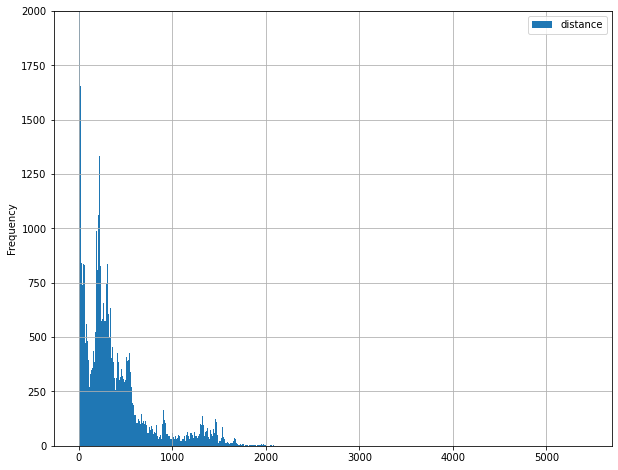

In [18]:
df_dist = df_order_merged.select('distance').toPandas()
df_dist.plot.hist(bins=1500, ylim=(0,2000), grid=True, figsize=[10,8])
display(df_dist.describe())

## Merge the customer reviews

In [19]:
df_order_merged = df_order_merged.join(df_customer_reviews.select('order_id', 'survey_score'), on=['order_id'], how='inner')
display(df_order_merged.limit(10))

order_id,customer_zip_code_prefix,seller_zip_code_prefix,customer_id,seller_id,product_id,order_item_id,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,order_status,order_purchase_timestamp,order_approved_at,order_carrier_delivery_date,order_customer_delivery_date,order_estimated_delivery_date,product_dim_cm,distance,survey_score
3168875baaa7b1b7b...,02053,14940,8cdbc6c14192efc82...,4a3ca9315b744ce9f...,1f30aacc69904c0d0...,1,135.0,16.61,cama_mesa_banho,58,293,1,1850,delivered,2018-03-28 17:46:58,2018-03-28 18:08:46,2018-04-04 00:08:23,2018-04-11 18:48:44,2018-04-16 00:00:00,12000,186.2724794462031,5
7ab737441b79ec93e...,02053,14940,bb7874514104785ce...,d2374cbcbb3ca4ab1...,0152f69b6cf919bcd...,1,13.9,11.85,cama_mesa_banho,40,116,1,250,delivered,2018-03-03 21:20:15,2018-03-06 03:51:19,2018-03-08 21:18:24,2018-03-29 00:52:30,2018-04-05 00:00:00,4800,186.2724794462031,3
0996218f2d0c8ec0c...,02053,07112,2c94ee4423f153e13...,8581055ce74af1dab...,a50acd33ba7a8da8e...,1,117.3,12.81,automotivo,53,555,1,4105,delivered,2018-04-02 19:13:49,2018-04-02 19:28:41,2018-04-04 19:05:46,2018-04-05 20:08:40,2018-04-12 00:00:00,44890,6.478096287460243,5
0996218f2d0c8ec0c...,02053,07112,2c94ee4423f153e13...,8581055ce74af1dab...,dfb97c88e066dc221...,2,139.0,15.88,automotivo,53,597,1,5417,delivered,2018-04-02 19:13:49,2018-04-02 19:28:41,2018-04-04 19:05:46,2018-04-05 20:08:40,2018-04-12 00:00:00,90992,6.478096287460243,5
b7d6b37701289908b...,02053,11701,f0605edc06e3b81fd...,e9779976487b77c6d...,fef63ef09494166bd...,1,58.0,8.27,esporte_lazer,57,3119,11,375,delivered,2017-05-28 11:05:59,2017-05-28 11:15:11,2017-05-29 15:31:29,2017-05-30 18:48:58,2017-06-09 00:00:00,6525,36.4532508324584,5
663830a477534735b...,02053,87050,c1ddb7521d14db907...,128639473a139ac0f...,6a8631b72a2f8729b...,1,24.9,13.51,eletronicos,54,614,1,100,delivered,2018-07-15 12:37:12,2018-07-16 12:30:53,2018-07-16 14:33:00,2018-07-23 23:56:47,2018-08-13 00:00:00,1122,336.47540988332685,5
be787f15d899c8ef7...,02053,15025,774a68091890f5f1b...,1f50f920176fa81da...,0bcc3eeca39e10642...,1,59.0,13.43,ferramentas_jardim,57,339,2,1800,delivered,2017-12-11 21:11:11,2017-12-11 21:34:03,2017-12-13 21:29:21,2017-12-26 15:45:18,2018-01-04 00:00:00,32560,258.6147106802567,5
b7b4ac6cf1e3f2b55...,02053,89180,57f0e44aca47fb9bc...,519a7aa428f18d125...,96ac5914ae8307995...,1,29.9,23.01,moveis_sala,47,521,4,1250,delivered,2018-07-07 16:56:54,2018-07-07 17:10:10,2018-07-09 08:47:00,2018-07-12 18:22:09,2018-08-02 00:00:00,5408,322.98952366330946,5
27fd0c263b9d38e9c...,02053,89180,d1cd0d62067d359ad...,519a7aa428f18d125...,96ac5914ae8307995...,1,24.9,22.97,moveis_sala,47,521,4,1250,delivered,2018-07-30 21:54:00,2018-07-30 22:24:22,2018-07-31 08:40:00,2018-08-06 17:07:59,2018-08-17 00:00:00,5408,322.98952366330946,4
989efe8965cc3848a...,02943,14940,88b61cadc52207340...,951e8cef368f09bb3...,625522e2041f5759b...,1,58.99,17.32,cama_mesa_banho,41,582,1,1450,delivered,2018-05-08 20:41:49,2018-05-10 03:09:52,2018-05-11 12:52:00,2018-05-16 15:06:53,2018-05-22 00:00:00,29925,178.78291855475408,5


## Distribution plot of customer review

array([[<AxesSubplot:title={'center':'survey_score'}>]], dtype=object)

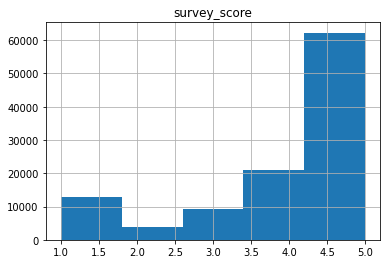

In [20]:
df_order_merged.select('survey_score').toPandas().hist(bins=5)

## Timestamps

   - **Merge the month**

In [21]:
get_month =  udf (lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S').month, IntegerType())
df_order_merged = df_order_merged.withColumn('month', get_month(col('order_purchase_timestamp')))

display(df_order_merged.limit(10))

order_id,customer_zip_code_prefix,seller_zip_code_prefix,customer_id,seller_id,product_id,order_item_id,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,order_status,order_purchase_timestamp,order_approved_at,order_carrier_delivery_date,order_customer_delivery_date,order_estimated_delivery_date,product_dim_cm,distance,survey_score,month
3168875baaa7b1b7b...,02053,14940,8cdbc6c14192efc82...,4a3ca9315b744ce9f...,1f30aacc69904c0d0...,1,135.0,16.61,cama_mesa_banho,58,293,1,1850,delivered,2018-03-28 17:46:58,2018-03-28 18:08:46,2018-04-04 00:08:23,2018-04-11 18:48:44,2018-04-16 00:00:00,12000,186.2724794462031,5,3
7ab737441b79ec93e...,02053,14940,bb7874514104785ce...,d2374cbcbb3ca4ab1...,0152f69b6cf919bcd...,1,13.9,11.85,cama_mesa_banho,40,116,1,250,delivered,2018-03-03 21:20:15,2018-03-06 03:51:19,2018-03-08 21:18:24,2018-03-29 00:52:30,2018-04-05 00:00:00,4800,186.2724794462031,3,3
0996218f2d0c8ec0c...,02053,07112,2c94ee4423f153e13...,8581055ce74af1dab...,a50acd33ba7a8da8e...,1,117.3,12.81,automotivo,53,555,1,4105,delivered,2018-04-02 19:13:49,2018-04-02 19:28:41,2018-04-04 19:05:46,2018-04-05 20:08:40,2018-04-12 00:00:00,44890,6.478096287460243,5,4
0996218f2d0c8ec0c...,02053,07112,2c94ee4423f153e13...,8581055ce74af1dab...,dfb97c88e066dc221...,2,139.0,15.88,automotivo,53,597,1,5417,delivered,2018-04-02 19:13:49,2018-04-02 19:28:41,2018-04-04 19:05:46,2018-04-05 20:08:40,2018-04-12 00:00:00,90992,6.478096287460243,5,4
b7d6b37701289908b...,02053,11701,f0605edc06e3b81fd...,e9779976487b77c6d...,fef63ef09494166bd...,1,58.0,8.27,esporte_lazer,57,3119,11,375,delivered,2017-05-28 11:05:59,2017-05-28 11:15:11,2017-05-29 15:31:29,2017-05-30 18:48:58,2017-06-09 00:00:00,6525,36.4532508324584,5,5
663830a477534735b...,02053,87050,c1ddb7521d14db907...,128639473a139ac0f...,6a8631b72a2f8729b...,1,24.9,13.51,eletronicos,54,614,1,100,delivered,2018-07-15 12:37:12,2018-07-16 12:30:53,2018-07-16 14:33:00,2018-07-23 23:56:47,2018-08-13 00:00:00,1122,336.47540988332685,5,7
be787f15d899c8ef7...,02053,15025,774a68091890f5f1b...,1f50f920176fa81da...,0bcc3eeca39e10642...,1,59.0,13.43,ferramentas_jardim,57,339,2,1800,delivered,2017-12-11 21:11:11,2017-12-11 21:34:03,2017-12-13 21:29:21,2017-12-26 15:45:18,2018-01-04 00:00:00,32560,258.6147106802567,5,12
b7b4ac6cf1e3f2b55...,02053,89180,57f0e44aca47fb9bc...,519a7aa428f18d125...,96ac5914ae8307995...,1,29.9,23.01,moveis_sala,47,521,4,1250,delivered,2018-07-07 16:56:54,2018-07-07 17:10:10,2018-07-09 08:47:00,2018-07-12 18:22:09,2018-08-02 00:00:00,5408,322.98952366330946,5,7
27fd0c263b9d38e9c...,02053,89180,d1cd0d62067d359ad...,519a7aa428f18d125...,96ac5914ae8307995...,1,24.9,22.97,moveis_sala,47,521,4,1250,delivered,2018-07-30 21:54:00,2018-07-30 22:24:22,2018-07-31 08:40:00,2018-08-06 17:07:59,2018-08-17 00:00:00,5408,322.98952366330946,4,7
989efe8965cc3848a...,02943,14940,88b61cadc52207340...,951e8cef368f09bb3...,625522e2041f5759b...,1,58.99,17.32,cama_mesa_banho,41,582,1,1450,delivered,2018-05-08 20:41:49,2018-05-10 03:09:52,2018-05-11 12:52:00,2018-05-16 15:06:53,2018-05-22 00:00:00,29925,178.78291855475408,5,5


display(df_order_merged.count())
display(df_order_merged.count())
display(df_order_merged.count())
display(df_order_merged.count())
display(df_order_merged.count())
display(df_order_merged.count())
   - **Plot of orders per month**

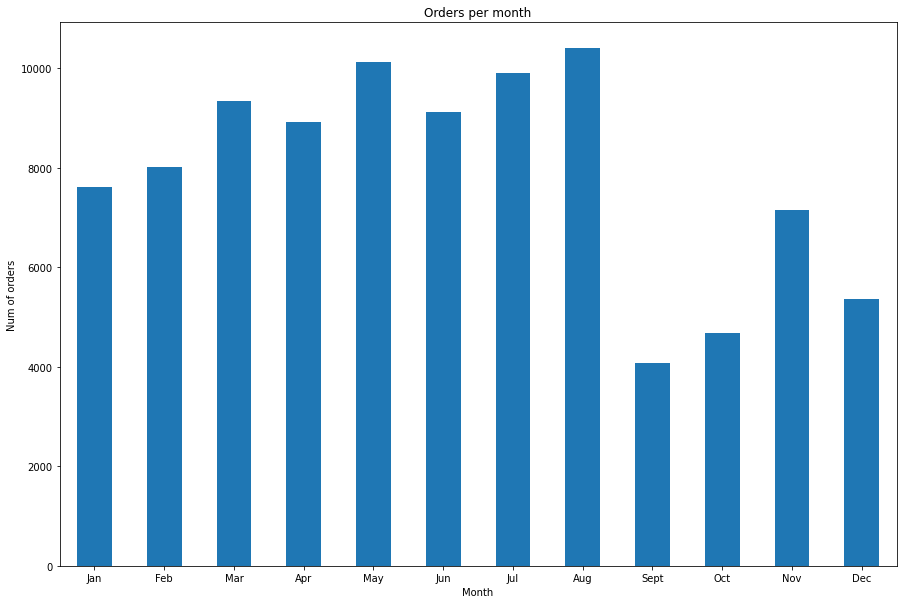

In [22]:
df_pd_timestamps = df_order_merged.select('order_id','order_purchase_timestamp').toPandas()
df_pd_timestamps.groupby(df_pd_timestamps['order_purchase_timestamp'].astype('datetime64[ns]').dt.month)\
    .agg({"order_id": "nunique"})\
    .plot(figsize=(15,10), kind="bar",
          title="Orders per month",
          ylabel="Num of orders",
          xlabel="Month",
          legend=False)
plt.xticks(np.arange(0,12), ['Jan','Feb','Mar','Apr','May','Jun',
                             'Jul','Aug','Sept','Oct','Nov','Dec'], 
           rotation='horizontal')
plt.show()


In [23]:
pp.pprint(get_columns([df_order_merged]))

{   'df_order_merged': {   'columns': [   'order_id',
                                          'customer_zip_code_prefix',
                                          'seller_zip_code_prefix',
                                          'customer_id',
                                          'seller_id',
                                          'product_id',
                                          'order_item_id',
                                          'price',
                                          'freight_value',
                                          'product_category_name',
                                          'product_name_lenght',
                                          'product_description_lenght',
                                          'product_photos_qty',
                                          'product_weight_g',
                                          'order_status',
                                          'order_purchase_timestamp',
             

## Create a incrementing id for product_catergory

In [24]:
df_product_category_name_translation = df_product_category_name_translation.withColumn("cat_id", F.monotonically_increasing_id())
df_order_merged = df_order_merged.join(df_product_category_name_translation.select('product_category_name','cat_id'), on=['product_category_name'], how='inner')
df_order_merged = df_order_merged.withColumn('cat_id', df_order_merged['cat_id'].cast(IntegerType()))

In [25]:
df_order_merged.schema

StructType(List(StructField(product_category_name,StringType,true),StructField(order_id,StringType,true),StructField(customer_zip_code_prefix,StringType,true),StructField(seller_zip_code_prefix,StringType,true),StructField(customer_id,StringType,true),StructField(seller_id,StringType,true),StructField(product_id,StringType,true),StructField(order_item_id,StringType,true),StructField(price,FloatType,true),StructField(freight_value,FloatType,true),StructField(product_name_lenght,IntegerType,true),StructField(product_description_lenght,IntegerType,true),StructField(product_photos_qty,IntegerType,true),StructField(product_weight_g,IntegerType,true),StructField(order_status,StringType,true),StructField(order_purchase_timestamp,StringType,true),StructField(order_approved_at,StringType,true),StructField(order_carrier_delivery_date,StringType,true),StructField(order_customer_delivery_date,StringType,true),StructField(order_estimated_delivery_date,StringType,true),StructField(product_dim_cm,Int

In [26]:
df_order_merged.limit(10)

product_category_name,order_id,customer_zip_code_prefix,seller_zip_code_prefix,customer_id,seller_id,product_id,order_item_id,price,freight_value,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,order_status,order_purchase_timestamp,order_approved_at,order_carrier_delivery_date,order_customer_delivery_date,order_estimated_delivery_date,product_dim_cm,distance,survey_score,month,cat_id
cama_mesa_banho,3168875baaa7b1b7b...,02053,14940,8cdbc6c14192efc82...,4a3ca9315b744ce9f...,1f30aacc69904c0d0...,1,135.0,16.61,58,293,1,1850,delivered,2018-03-28 17:46:58,2018-03-28 18:08:46,2018-04-04 00:08:23,2018-04-11 18:48:44,2018-04-16 00:00:00,12000,186.2724794462031,5,3,3
cama_mesa_banho,7ab737441b79ec93e...,02053,14940,bb7874514104785ce...,d2374cbcbb3ca4ab1...,0152f69b6cf919bcd...,1,13.9,11.85,40,116,1,250,delivered,2018-03-03 21:20:15,2018-03-06 03:51:19,2018-03-08 21:18:24,2018-03-29 00:52:30,2018-04-05 00:00:00,4800,186.2724794462031,3,3,3
automotivo,0996218f2d0c8ec0c...,02053,07112,2c94ee4423f153e13...,8581055ce74af1dab...,a50acd33ba7a8da8e...,1,117.3,12.81,53,555,1,4105,delivered,2018-04-02 19:13:49,2018-04-02 19:28:41,2018-04-04 19:05:46,2018-04-05 20:08:40,2018-04-12 00:00:00,44890,6.478096287460243,5,4,2
automotivo,0996218f2d0c8ec0c...,02053,07112,2c94ee4423f153e13...,8581055ce74af1dab...,dfb97c88e066dc221...,2,139.0,15.88,53,597,1,5417,delivered,2018-04-02 19:13:49,2018-04-02 19:28:41,2018-04-04 19:05:46,2018-04-05 20:08:40,2018-04-12 00:00:00,90992,6.478096287460243,5,4,2
esporte_lazer,b7d6b37701289908b...,02053,11701,f0605edc06e3b81fd...,e9779976487b77c6d...,fef63ef09494166bd...,1,58.0,8.27,57,3119,11,375,delivered,2017-05-28 11:05:59,2017-05-28 11:15:11,2017-05-29 15:31:29,2017-05-30 18:48:58,2017-06-09 00:00:00,6525,36.4532508324584,5,5,5
eletronicos,663830a477534735b...,02053,87050,c1ddb7521d14db907...,128639473a139ac0f...,6a8631b72a2f8729b...,1,24.9,13.51,54,614,1,100,delivered,2018-07-15 12:37:12,2018-07-16 12:30:53,2018-07-16 14:33:00,2018-07-23 23:56:47,2018-08-13 00:00:00,1122,336.47540988332685,5,7,32
ferramentas_jardim,be787f15d899c8ef7...,02053,15025,774a68091890f5f1b...,1f50f920176fa81da...,0bcc3eeca39e10642...,1,59.0,13.43,57,339,2,1800,delivered,2017-12-11 21:11:11,2017-12-11 21:34:03,2017-12-13 21:29:21,2017-12-26 15:45:18,2018-01-04 00:00:00,32560,258.6147106802567,5,12,16
moveis_sala,b7b4ac6cf1e3f2b55...,02053,89180,57f0e44aca47fb9bc...,519a7aa428f18d125...,96ac5914ae8307995...,1,29.9,23.01,47,521,4,1250,delivered,2018-07-07 16:56:54,2018-07-07 17:10:10,2018-07-09 08:47:00,2018-07-12 18:22:09,2018-08-02 00:00:00,5408,322.98952366330946,5,7,42
moveis_sala,27fd0c263b9d38e9c...,02053,89180,d1cd0d62067d359ad...,519a7aa428f18d125...,96ac5914ae8307995...,1,24.9,22.97,47,521,4,1250,delivered,2018-07-30 21:54:00,2018-07-30 22:24:22,2018-07-31 08:40:00,2018-08-06 17:07:59,2018-08-17 00:00:00,5408,322.98952366330946,4,7,42
cama_mesa_banho,989efe8965cc3848a...,02943,14940,88b61cadc52207340...,951e8cef368f09bb3...,625522e2041f5759b...,1,58.99,17.32,41,582,1,1450,delivered,2018-05-08 20:41:49,2018-05-10 03:09:52,2018-05-11 12:52:00,2018-05-16 15:06:53,2018-05-22 00:00:00,29925,178.78291855475408,5,5,3


## Using a smaller dataframe for the final K-Means model.
  - ### Using a dataset split of 60%, 10%, 30% for the train, validation and test datasets
  - ### To prevent the kernel crashes the train, test data sets have been restricted to 30,000 and 20,000 data points

In [27]:
features = ['distance', 'survey_score', 'month', 'price', 'freight_value' , 'product_dim_cm', 'product_weight_g', 'product_photos_qty', 'cat_id']
features_ = ['distance', 'survey_score', 'month', 'price', 'freight_value' , 'product_dim_cm', 'product_weight_g', 'product_photos_qty', 'cat_id','product_id','customer_id']

df_order_merged_short = df_order_merged.select(features_)
#df_order_merged = df_order_merged.select(features)
VA = VectorAssembler(inputCols=features, outputCol='features')
transformed_data = VA.transform(df_order_merged_short)

train_df,val_df,  test_df = transformed_data.randomSplit([0.6, 0.1,0.3], seed = 42)


## Check the datatypes of the columns before fitting it to the model

In [28]:
display(df_order_merged_short.schema)

StructType(List(StructField(distance,DoubleType,true),StructField(survey_score,IntegerType,true),StructField(month,IntegerType,true),StructField(price,FloatType,true),StructField(freight_value,FloatType,true),StructField(product_dim_cm,IntegerType,true),StructField(product_weight_g,IntegerType,true),StructField(product_photos_qty,IntegerType,true),StructField(cat_id,IntegerType,false),StructField(product_id,StringType,true),StructField(customer_id,StringType,true)))

## Scale the train, validation, test datasets

In [29]:
print("Fit the trained data and create a scaler model")
scale = StandardScaler(inputCol='features',outputCol='scaled')

train_df = train_df.limit(N_TRAIN_DATA)
train_scaled_data = scale.fit(train_df)
train_scaled_data_output = train_scaled_data.transform(train_df)
train_scaled_data_output.show(2)

print("Fit the test data to the scaler model")
test_df = test_df.limit(N_TEST_DATA)
test_scaled_data_output = train_scaled_data.transform(test_df)
test_scaled_data_output.show(2)

print("Fit the validation data to the scaler model")
val_scaled_data_output = train_scaled_data.transform(val_df)
val_scaled_data_output.show(2)


print("Number of rows in train_df = {}, val_df = {}, test_df = {}".format(N_TRAIN_DATA,val_df.count(), N_TEST_DATA))

Fit the trained data and create a scaler model
+-----------------+------------+-----+-----+-------------+--------------+----------------+------------------+------+--------------------+--------------------+--------------------+--------------------+
|         distance|survey_score|month|price|freight_value|product_dim_cm|product_weight_g|product_photos_qty|cat_id|          product_id|         customer_id|            features|              scaled|
+-----------------+------------+-----+-----+-------------+--------------+----------------+------------------+------+--------------------+--------------------+--------------------+--------------------+
|2.295458467223866|           5|    7|15.99|         7.39|          8000|             250|                 2|    12|c2c00c360a8407127...|01f841d4c59e8b763...|[2.29545846722386...|[0.00628629665383...|
|3.021365960240162|           5|   12| 29.0|         8.72|          6000|             325|                 4|     7|170b033abb14ccc92...|683765c80b88

## Results

  - ### Find the optimal 'k' for clustering

In [30]:
silhouette_score=[]
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='scaled', \
                                metricName='silhouette', distanceMeasure='squaredEuclidean')

for i in range(2,15):    
    KMeans_algo=KMeans(featuresCol='scaled', k=i)
    KMeans_fit=KMeans_algo.fit(train_scaled_data_output)    
    output=KMeans_fit.transform(train_scaled_data_output)
    score=evaluator.evaluate(output)
    silhouette_score.append(score)
    print("Silhouette Score for k = {} : {}".format(i,score))


Silhouette Score for k = 2 : 0.7154185741524448
Silhouette Score for k = 3 : 0.3098066990821567
Silhouette Score for k = 4 : 0.29358178371419563
Silhouette Score for k = 5 : 0.2987095209119094
Silhouette Score for k = 6 : 0.3041229055406726
Silhouette Score for k = 7 : 0.25531200898935774
Silhouette Score for k = 8 : 0.2844162143852261
Silhouette Score for k = 9 : 0.3003896273958905
Silhouette Score for k = 10 : 0.3003355105400472
Silhouette Score for k = 11 : 0.26685786770597814
Silhouette Score for k = 12 : 0.3005346901436662
Silhouette Score for k = 13 : 0.2608738004931076
Silhouette Score for k = 14 : 0.2477006753074689


  - ### Plot of Cost against 'k'

Text(0, 0.5, 'cost')

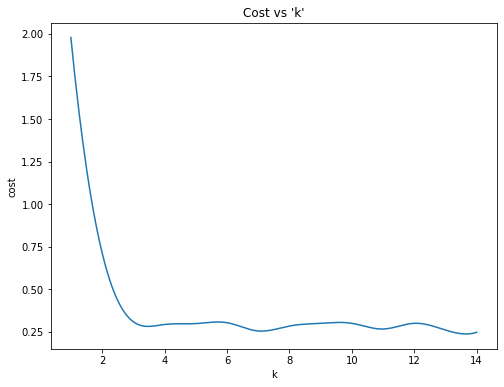

In [31]:
(x,y) = (range(2,15),silhouette_score)
x_new = np.linspace(1, 14, 200)
a_BSpline = make_interp_spline(x, y)
y_new = a_BSpline(x_new)

fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(x_new,y_new)
ax.set_title("Cost vs 'k'")
ax.set_xlabel('k')
ax.set_ylabel('cost')

## It can be seen from the above plot that a optimal value of k = 4

In [32]:
KMeans_algo=KMeans(featuresCol='scaled', k=4)
KMeans_fit=KMeans_algo.fit(train_scaled_data_output)    
train_output=KMeans_fit.transform(train_scaled_data_output)
score=evaluator.evaluate(train_output)
silhouette_score.append(score)
print("Silhouette Score for training data and k = {}: {}".format(4,score))

Silhouette Score for training data and k = 4: 0.29358178371419563


  - ### Plot the clusters

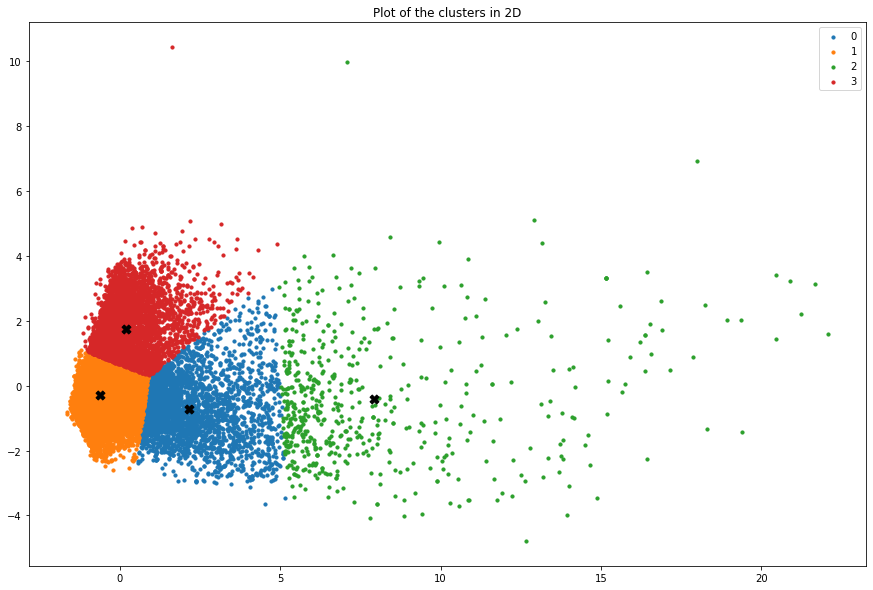

In [33]:
train_df = train_output.toPandas()
# unpack the dense scaled vectors
train_df_scaled = train_df['scaled'].apply(lambda x: pd.Series(x.toArray()))
# use PCA to reduce the dimension to 2
pca = PCA(2)
data_pca = pca.fit_transform(train_df_scaled)
kmeans_model = sklKMeans(n_clusters= 4)
label = kmeans_model.fit_predict(data_pca)
unique_labels = np.unique(label)
centroids = kmeans_model.cluster_centers_

fig, ax = plt.subplots(figsize=(15, 10))

for i in unique_labels:
    ax.scatter(data_pca[label == i , 0] , data_pca[label == i , 1] , label = i, s=10)

ax.scatter(centroids[:,0] , centroids[:,1] , s = 80, color = 'black', marker='X')
ax.set_title("Plot of the clusters in 2D")
plt.legend()
plt.show()

  - ### Score for the validation data

In [34]:
val_output=KMeans_fit.transform(val_scaled_data_output)
score=evaluator.evaluate(val_output)
print("Silhouette Score for validation data:",score)


Silhouette Score for validation data: 0.2927932745091702


  - ### Score for the test data

In [35]:
test_output=KMeans_fit.transform(test_scaled_data_output)
score=evaluator.evaluate(test_output)
print("Silhouette Score for test data:",score)


Silhouette Score for test data: 0.297981050113347


## Combine all the outputs together

In [36]:
Final_output = train_output.union(train_output.union(val_output)).dropna()

In [37]:
Final_output[Final_output['prediction']==3].sample(fraction=0.5)

distance,survey_score,month,price,freight_value,product_dim_cm,product_weight_g,product_photos_qty,cat_id,product_id,customer_id,features,scaled,prediction
198.33453976369512,5,7,99.99,71.78,112251,8250,1,3,22dd24a9dd84994cf...,8e4a4bf8cb5a4231d...,[198.334539763695...,[0.54315500430913...,3
210.36938402746296,4,11,1610.0,32.11,30912,3510,1,5,f209a7348b00e6af7...,90753daa6413261a9...,[210.369384027462...,[0.57611338813746...,3
252.22465480922648,5,1,289.0,46.48,53400,10150,3,7,4aa6014eceb682077...,359b9d6f7f8977275...,[252.224654809226...,[0.69073739568004...,3
262.16783233924406,4,11,139.99,32.01,64000,10700,1,11,83b00325c13c44245...,68bc16b896692f80d...,[262.167832339244...,[0.71796758282041...,3
308.96169782395975,3,8,795.0,63.65,51975,9050,8,63,f49e985b4cb2d0543...,69f32d82d34e7b1a4...,[308.961697823959...,[0.84611632705464...,3
313.0098992106862,5,7,159.9,60.35,62640,7474,4,3,0ec7b6a863e219792...,5500c1fe2f5362793...,[313.009899210686...,[0.85720265041653...,3
313.23958502541706,5,5,219.0,54.06,83549,16200,2,23,fb1e2262cc73f7ab2...,1cefecd08a908f264...,[313.239585025417...,[0.85783166339550...,3
313.88202851765914,5,8,149.99,57.53,31584,8250,3,25,c28d0e4df4c650713...,14e7871569ad7387e...,[313.882028517659...,[0.85959104629579...,3
184.8796023402937,5,7,630.0,64.49,2560,23450,1,3,13b4ff901d43edec6...,92dd835c0a01f4740...,[184.879602340293...,[0.50630758175281...,3
259.46477003230837,5,9,279.99,47.43,65664,8250,4,14,9fd2f153a01bbc71f...,b321c76c00ab4ac26...,[259.464770032308...,[0.71056503044239...,3


## Product Recommendations
  - ### Assume there were 5 purchases and we generated the test outputs
  - ### Use the test output prediction labels and filter the Final_output dataframe
  - ### Randomly choose 3 products from the cluster for each purchase

In [38]:
sample_test = test_output.limit(5)

In [39]:
purchase_list = sample_test.select('product_id', 'customer_id', 'prediction').toPandas().values.tolist()

In [40]:
for item in purchase_list:
    print('Product : {} purchased by the customer :{}'.format(item[0],item[1]))
    print('Top 3 recommended products for the specific customer')
    display(Final_output[Final_output['prediction']==item[2]].sample(fraction=0.5).limit(3))

Product : 6b75ce117b8fcc75289cb6cbe589de6c purchased by the customer :71af36f53c0fe0b5b886ffad8154c5db
Top 3 recommended products for the specific customer


distance,survey_score,month,price,freight_value,product_dim_cm,product_weight_g,product_photos_qty,cat_id,product_id,customer_id,features,scaled,prediction
6.478096287460243,5,4,117.3,12.81,44890,4105,1,2,a50acd33ba7a8da8e...,2c94ee4423f153e13...,[6.47809628746024...,[0.01774078494407...,1
12.265322028224537,4,4,219.0,9.3,2700,292,2,9,d04e48982547095af...,63368406d4bb7f949...,[12.2653220282245...,[0.03358956562498...,1
30.60662347612332,5,12,79.99,8.75,8960,250,1,22,ccc4bd1600ccbb62e...,a0edaa97421af6b1d...,[30.6066234761233...,[0.08381868698144...,1


Product : a2da86fa759178e9e58e54aa1a144e59 purchased by the customer :68cb7fbc85416655ad0499fcc7fdb9f7
Top 3 recommended products for the specific customer


distance,survey_score,month,price,freight_value,product_dim_cm,product_weight_g,product_photos_qty,cat_id,product_id,customer_id,features,scaled,prediction
6.271393215280431,5,4,29.9,7.39,15840,150,6,0,adf591c625cb265c1...,47ed1ad73b7883c3f...,[6.27139321528043...,[0.01717471204424...,2
7.028794344256277,5,8,30.0,8.37,11270,500,6,43,37f4d0bf85fbf875c...,dc7b3fbf491155c69...,[7.02879434425627...,[0.01924891562957...,2
14.914633111221498,5,1,134.17,27.38,43560,10400,10,11,9523f1a3e7db9e38d...,a8c5c582c453d8fe3...,[14.9146331112214...,[0.04084491597604...,2


Product : dfb97c88e066dc22165f31648efe1312 purchased by the customer :2c94ee4423f153e13ce3fb15ac406a13
Top 3 recommended products for the specific customer


distance,survey_score,month,price,freight_value,product_dim_cm,product_weight_g,product_photos_qty,cat_id,product_id,customer_id,features,scaled,prediction
18.645394688770942,5,1,49.9,8.27,8000,100,2,6,473795a355d29305c...,b930ac822ab2d45dd...,[18.6453946887709...,[0.05106190502466...,1
26.103049476398382,5,3,110.0,13.05,50400,7800,3,44,88e84a987b4681434...,7302aa13024a3e490...,[26.1030494763983...,[0.07148528928812...,1
26.528569471573803,4,1,155.0,8.83,5967,350,3,33,e40fa115d27ea4a80...,7e27f4fc651dbbb8e...,[26.5285694715738...,[0.07265060983737...,1


Product : 37f4d0bf85fbf875c920d460766d6a5c purchased by the customer :db7432cb997db7083db6aaea715d3433
Top 3 recommended products for the specific customer


distance,survey_score,month,price,freight_value,product_dim_cm,product_weight_g,product_photos_qty,cat_id,product_id,customer_id,features,scaled,prediction
22.111542860294147,5,3,49.9,10.96,3136,600,4,7,1720f85e4a07f5701...,e785a41a19890a8f1...,[22.1115428602941...,[0.06055422909128...,2
24.10704168477952,5,12,118.6,8.09,2288,250,7,17,7a7416293b9692d84...,9f11f34a505da5700...,[24.1070416847795...,[0.06601906226609...,2
25.923252137933993,4,1,129.9,9.1,4800,550,4,23,f0f464c1300173b9e...,0b79f3d959c1308c5...,[25.9232521379339...,[0.07099289989258...,2


Product : 2136c70bbe723d338fab53da3c03e6dc purchased by the customer :70a8cfb1730fd53e5c15f2a62e1e5448
Top 3 recommended products for the specific customer


distance,survey_score,month,price,freight_value,product_dim_cm,product_weight_g,product_photos_qty,cat_id,product_id,customer_id,features,scaled,prediction
13.19973867236129,1,8,5.9,7.39,4590,250,1,7,9a4b54310a69c82a6...,16d5e579f5c682f59...,[13.1997386723612...,[0.03614854036018...,0
16.74617105631575,1,5,579.99,16.96,16000,3750,3,25,71f2ce4ae5dfdd3b5...,ee78e2394f33a3bf7...,[16.7461710563157...,[0.04586072916543...,0
19.282037475200585,1,5,38.7,8.29,4096,450,1,29,c9e5a053551073d27...,705b9e5a5d27aaed4...,[19.2820374752005...,[0.05280540222802...,0


## Stop Spark session

In [42]:
spark.stop()